# CASCADES

# Preliminaries

In [1]:
import sympy
import tellurium as te
import numpy as np
import pandas as pd

# Single element cascade

There is a single species, two inputs (left and right) and two outputs.
\begin{eqnarray}
\dot{S} (t) & = & v^L(t) + v^R(t) - k^L S(t) - k^R S(t) \\
S(s) & = & \frac{v^L(s) + v^R (s)}{ s + k^L  + k^R } \\
\end{eqnarray}

From the final value theorm, we see that $S \rightarrow 0$ if $v^L = 0 = v^R$, which makes intuitive sense.

Note that
\begin{eqnarray}
H^L(s) & = & \frac{S(s)}{v^L(s)} \\
&= & \frac{1}{ s + k^L  + k^R } \\
& = & \frac{S(s)}{v^R(s)} \\
& = & H^R(s) \\
& = & H(s) \\
\end{eqnarray}
That is
$S(s) = H(s) (v^L(s) +  v^R(s))$.

Let $S_n$ be the $n$th species in the cascade with parameters $v^L_{n}, v^R_{n}, k^L_n, k^R_n$.
Consider a two species cascade so that
$n \in {1, 2}$, and
$v^L_1 = 0$ and $v^R_2 = 0$. So we have
\begin{eqnarray}
S_1(s) & = & H_1(s) v_1^R(s) \\
S_2(s) & = & H_2(s) v_2^L(s) \\
v^R_1 (s) & = & S_2 (s) k^L_2 \\
v^R_2 (s) & = & S_1 (s) k^R_2 \\
\end{eqnarray}
and so
\begin{eqnarray}
S_1(s) & = & H_1(s) S_2 (s) k^L_2  \\
S_2(s) & = & H_2(s) S_1 (s) k^R_1  \\
\end{eqnarray}
Substituting,
\begin{eqnarray}
H_1(s) & = & \frac{1}{ H_2(s)  k^R_1  k^L_2 } \\
\end{eqnarray}

\begin{eqnarray}
 H_1(s)& = & \frac{s + k^L_2 }{ k^R_1  k^L_2 } \\
\end{eqnarray}

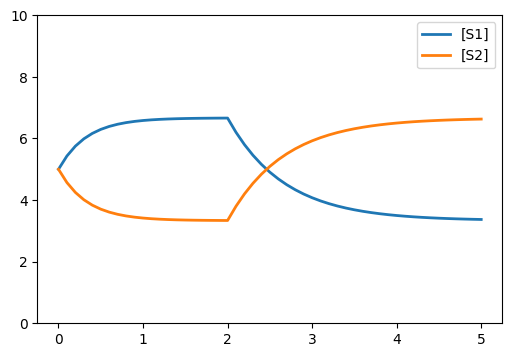

In [2]:
model = """
S1 -> S2; kR1 * S1
S2 -> S1; kL2 * S2

S1 = 5
S2 = 5
kR1 = 1
kL2 = 2

at (time > 2): kL2 = 0.5
"""
rr = te.loada(model)
rr.simulate()
rr.plot(ylim=[0, 10])

# Steady state for n stage cascade

At steady state, the rates across each stage must be the same. That is,
\begin{eqnarray}
k^R_{n-1}S_{n-1} &= &k^L{n}S_{n} \\
\end{eqnarray}
Also, $\sum_n S_n = T$.

So, for an $N$ stage cascade:
\begin{eqnarray}
k^R_{n-1}S_{n-1} &= &k^L{n}S_{n} \\
S_{n} &= & \frac{k^L_{n+1}}{k^R_{n}} S_{n+1} \\
S_{n} &= & \prod_{j=n}^{N-1}\frac{k^L_{j+1}}{k^R_{j}} S_{N} \\
\end{eqnarray}
where $k^L_j =0$ for $j \leq 1$ and $k^R_j = 0$ for $j \geq N$.

And,
\begin{eqnarray}
T & = & \sum_n S_n \\
& = & S_N + \sum_{n=1}^{N-1} \prod_{j=n}^{N-1}\frac{k^L_{j+1}}{k^R_{j}} S_{N} \\
S_N & = &  \frac{T}{1 + \sum_{n=1}^{N-1} \prod_{j=n}^{N-1}\frac{k^L_{j+1}}{k^R_{j}} } \\
S_n & = & \frac{T \prod_{j=n}^{N-1}\frac{k^L_{j+1}}{k^R_{j}} }{1 + \sum_{n=1}^{N-1} \prod_{j=n}^{N-1}\frac{k^L_{j+1}}{k^R_{j}} }, ~ n < N \\
\end{eqnarray}

Let $r_n = \frac{k^L_n+1}{k^R_n}$. Then
$S_n = \frac{T \prod_{j=n}^{N-1} r_n  }{1 + \sum_{m=1}^{N-1} \prod_{j=m}^{N-1} r_j  }$

## Verification of steady state result

In [54]:
def calculateSteadyState(rvec, total):
    """ 
    Calculates the steady state value of each species.

    Args:
        rvec: array-float (dimension N-1. rvec[n] = r_n)
        total: float (T)
    Returns
        svec: array-float (dimension N)
    """
    num_r = len(rvec)
    num_species = num_r + 1 
    prods = []
    indices = list(range(num_r))
    # Calculate the products for each position in the cascade
    for idx in indices:
        pos = num_r - idx - 1
        prods.insert(0, rvec[pos])
        if pos < num_r - 1:
            prods[0] *= prods[1]
    # 
    denominator = 1 + np.sum(prods)
    result_arr = total*np.append(prods, [1])/denominator
    return result_arr

# TESTS
result = calculateSteadyState(np.array([17.0, 0.45, 1/3.]), 10) 
result

array([6.32231405, 0.37190083, 0.82644628, 2.47933884])

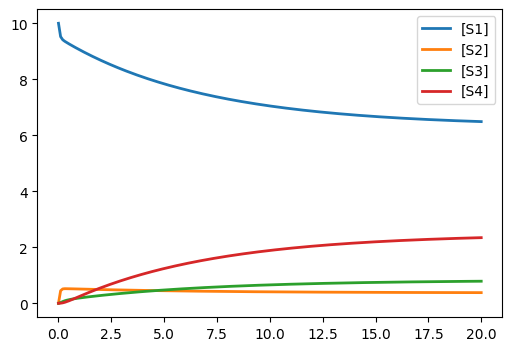

[S1]: 6.322
[S2]: 0.372
[S3]: 0.826
[S4]: 2.479


In [49]:
MODEL = """
S1 -> S2; k12*S1
S2 -> S1; k21*S2
S2 -> S3; k23*S2
S3 -> S2; k32*S3
S3 -> S4; k34*S3
S4 -> S3; k43*S4

k12 = 1;
k21 = 17;
k23 = 1;
k32 = 0.45
k34 = 3
k43 = 1
TOTAL = 10
S1 = TOTAL
S2 = 0
S3 = 0
S4 = 0
"""
rr = te.loada(MODEL)
rr.simulate(0, 20, 200)
rr.plot()
rr.steadyState()
for idx in range(4):
    name = "[S%d]" % (idx + 1)
    print("%s: %2.3f" % (name, rr[name]))

# Effect of a change in kinetic rates

## Products of ratios: $P(i, j)$

\begin{eqnarray}
P (i, j) & = & \prod_{l=i}^j r_l \text{ for } i \leq j; 0 \text{ otherwise} \\
P (i) & = & P (i,N-1)\\
D & = & 1 + \sum_{m=1}^{N-1} P(m) \\
S_n & = & \frac{T P(n)}{D},~ n<N \\
S_N & = & \frac{T}{D } \\
\end{eqnarray}

## Derivatives

\begin{eqnarray}
\frac{\partial P(i,j)}{\partial r_m} & = &  \frac{P(i,j)}{r_m}, i \leq m \\
& = & 0, \text{ otherwise}
\end{eqnarray}

\begin{eqnarray}
\frac{ \partial D}{\partial r_m} & = & 
\sum_{l=1}^{k} \frac{P(l, m)}{r_m} \\
\end{eqnarray}

\begin{eqnarray}
\frac{\partial S_n}{\partial r_m} & = & 
T\frac{ D \frac{   \partial P(n)}{\partial r_m}
- 
P(n) \frac{\partial D}{\partial r_m} } 
{D^2 } \\
& = & 
T\frac{P(n)}{r_m}
\left(
\frac{1}{D}
- 
\frac{\sum_{l=1}^{m}  P(l, m) } 
{D^2 } \right) \\
\frac{\partial S_N}{\partial r_m} & = & 
-\frac{T P(n)}{r_m}
\frac{\sum_{l=1}^{m}  P(l, m) } 
{D^2 } \\
\end{eqnarray}

## Control Coefficients

The scaled elasticity is for $S_n$, $n < N$ w.r.t. $r_m$ is

\begin{eqnarray}
\mathcal{C}_{r_m}^{S_N} & = &
-
\frac{\sum_{l=1}^{m}  P(l, m) } 
{D } \\
\mathcal{E}^{r_m}_{k^L_m} & = &
\frac{1}{k^R_m} \frac{1}{r_m}{k^L_m} \\
& = & 1 \\
\mathcal{C}^{S_N}_{k^L_m} & = &
\mathcal{C}^{S_N}_{r_m} \\
\mathcal{E}^{r_m}_{k^R_m} & = &
\frac{-k^L_m}{(k^R_m)^2} \frac{1}{r_m}{ k^R_m} \\
& = & -1 \\
\mathcal{C}^{S_N}_{k^R_m} & = &
-\mathcal{C}^{S_N}_{r_m} \\
\end{eqnarray}

Note can get very large control coefficient in 2 cycle cascade if $r_1$ is large and $r_2$ is smaller than 1.

Consider
1. Descending and increasing sequences of $r_i$
1. 3 species cascade
1. Normalized sensitivity
1. Conditions when get hypersensitivity

The scaled control coefficient is for $S_n$, $n < N$ w.r.t. $r_i$ is
\begin{eqnarray}
\mathcal{C}_{r_i}^{S_n} & = &
\frac{ \frac{\partial S_n}{S_n} } {\frac{\partial r_i}{r_i}} \\
& = &  \frac{\partial S_n}{\partial r_i} \frac{r_i}{S_n} \\
& = & \frac{r_i}{S_n}
\frac{1}{r_i}
\frac{ D  P(n, i) P(i+1)
- 
P(n) \sum_{m=1}^{N-1}  P(m, i) P(i+1) } 
{D^2 } \\
& = &
 P(i+1) \frac{ D  P(n, i)
- 
P(n) \sum_{m=1}^{N-1}  P(m, i) } 
{D P(n)} \\
& = &
 P(i+1) \left( \frac{  P(n, i)}{P(n)}
-
\frac{ D -1 } 
{D} \right) \\
\end{eqnarray}

The scaled control coefficient is for $S_N$ w.r.t. $r_i$ is
\begin{eqnarray}
\mathcal{C}_{r_i}^{S_n}
& = &  \frac{\partial S_N}{\partial r_i} \frac{r_i}{S_N} \\
& = & -\frac{r_i}{S_N}
\frac{1}{r_i}
\frac{ 
 \sum_{m=1}^{N-1}  P(m, i) P(i+1) } 
{D^2 } \\
& = &
 - P(i+1) \frac{ 
\sum_{m=1}^{N-1}  P(m, i) } 
{D } \\
& = &
- P(i+1) 
\frac{ D -1 } 
{D} \\
\end{eqnarray}

Observations
1. Get hypersensitivty to stage $i$ if $r_n$ is large for $n \neq i$ and $r_i$ is small.
1. Suppose that $P(n,i) \approx P(n)$ if $i \leq n$, and $P(i+1) \approx R$.

# Bug

In [62]:
r = te.loada('''
J1: $Xo -> 2 x; k;
J2: x -> $X1; k3*x;

Xo = 1;
k = 1;
k1 = 0.15;
k2 = 0.12;
k3 = 0.05;
''')

r.steadyState()
print (r.x)
print (r.getScaledFluxControlCoefficientMatrix())
print(r.getScaledConcentrationControlCoefficientMatrix())

print (r.getCC ('J1', 'k'))
print (r.getCC ('J2', 'k'))
print (r.getCC ('J2', 'k3'))

39.99999999999997
      J1,           J2
J1 [[  1,            0],
J2  [  1, -6.66134e-16]]

     J1, J2
x [[  1, -1]]

1.0000000000000084
1.0000000000000084
0.0


In [90]:
CASCADE_MODEL = """
J1f: S1 -> S2; S1*k1;
;
J1b: S2 -> S1; S2*k2;
;
J2f: S2 -> S3; S2*k3;
;
J2b: S3 -> S2; S3*k4;
;
k1 = 1;
k2 = 1;
k3 = 1;
k4 = 1;
r1 = k2/k1;
r2 = k4/k3
S1 = 100;
S2 = 0;
S3 = 0;
"""

In [89]:
rr = te.loada(CASCADE_MODEL)
rr.steadyState()
print(rr.S1, rr.S2, rr.S3)
print(rr.getScaledConcentrationControlCoefficientMatrix())
print(rr.getCC("S3", "k1"))
print(rr.getCC("S3", "k2"))
expected_cc = -rr.r1/(1 + rr.r2*rr.r2 + rr.r2)
print(expected_cc)

33.33333333333319 33.333333333333066 33.333333333333755
            J1f,       J1b,       J2f,       J2b
S2 [[  0.333333, -0.333333, -0.333333,  0.333333],
S1  [ -0.666667,  0.666667, -0.333333,  0.333333],
S3  [  0.333333, -0.333333,  0.666667, -0.666667]]

0.3333332911565138
-0.33333333069933974
-0.3333333333333333


In [120]:
def calculateCC3(k2_val, k4_val=None, delta=0.01, size=3):
    """Calculates the control coefficient of S3 w.r.t. k2"""
    rr = te.loada(CASCADE_MODEL)
    if k4_val is not None:
        rr["k4"] = k4_val
    k2_arr = np.array([k2_val + n*delta for n in range(size)])
    s3s = []
    for idx in range(size):
        rr["k2"] = k2_arr[idx]
        rr.steadyState()
        s3s.append(rr["S3"])
    s3_arr = np.array(s3s)
    dk3_arr = np.diff(s3_arr)/delta
    r1_arr = k2_arr/rr["k1"]
    cc = r1_arr[:-1]*dk3_arr
    cc = np.mean(cc/s3_arr[:-1])
    return cc, dk3_arr, s3_arr, rr.getCC("S3", "k2")

# Tests
calculateCC3(1, k4_val=1)

(-0.33333149985761307,
 array([-11.07419712, -11.00085807]),
 array([33.33333333, 33.22259136, 33.11258278]),
 -0.3377483415570733)

In [84]:
np.diff(np.array(range(10)))

array([1, 1, 1, 1, 1, 1, 1, 1, 1])

## Notes

1. Need to find control coefficients in terms of the kinetic constants, not the ratios since the engineering cost is in terms of changing the $k$. This likely just involve the elasticity of $r_k$ w.r.t.
2. Applications of cascades
    1. 1 cycle cascade: sequestration
    2. 1 cycle cascade: signal attenuation
    3. 2 cycle cascade: signal amplification. This is a kind of electrical diode or [plumbing backflow preventer](https://southendplumbingllc.com/wp-content/uploads/2021/08/Backflow-Preventer-Diagram.jpg).
1. Extend to multiple layers by having rates multiplied by mass in state from the parent layer. Calculate control coefficients.